In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv("WAG_C_M.csv", sep = ";",index_col=['month'], parse_dates=['month'], dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


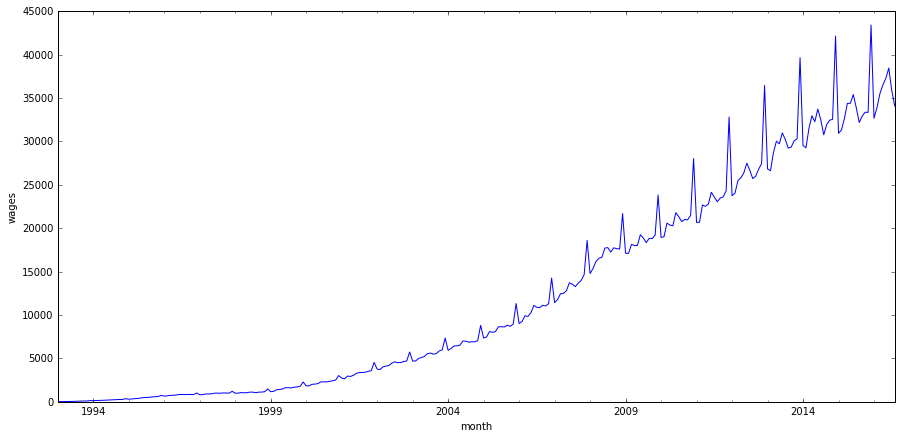

In [3]:
plt.figure(figsize(15, 7))
data.WAG_C_M.plot()
plt.ylabel("wages")
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


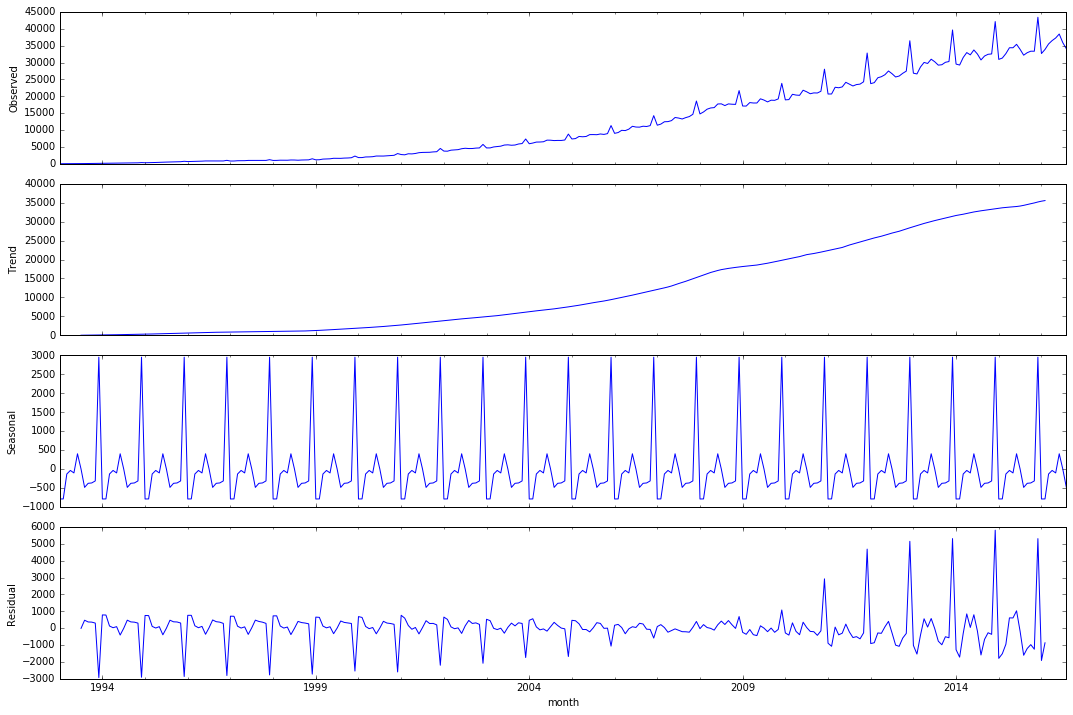

In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

На графиках выше явно виден тренд, со временем увеличивающаяся дисперсия и сезонность. Он явно нестационарный.
Выполним его преобразование.
Для начала разберемся с дисперсией.

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


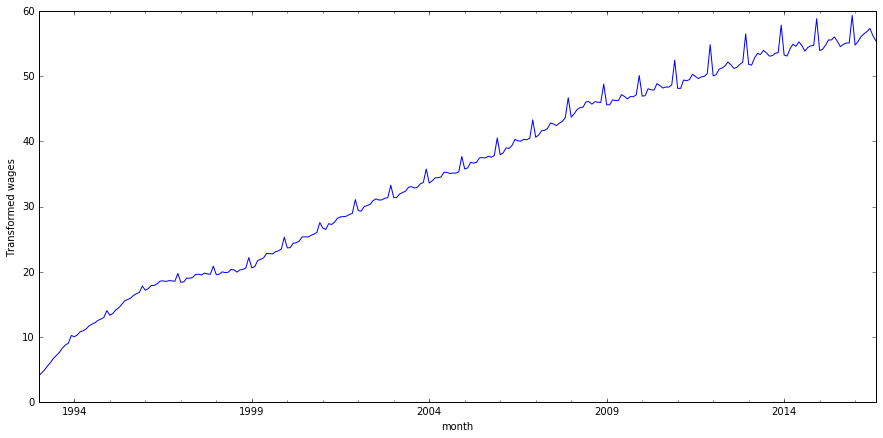

In [5]:
data['wages_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.wages_box.plot()
plt.ylabel(u'Transformed wages')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wages_box)[1])

Мы значительно стабилизировали дисперсию

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


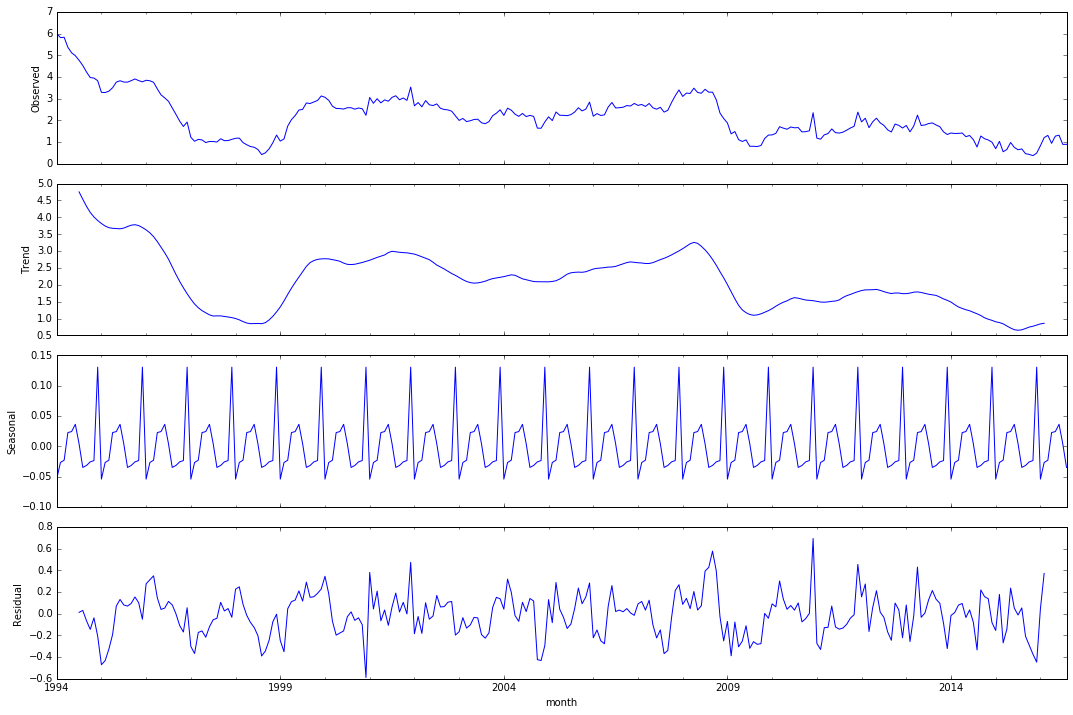

In [6]:
data['wages_box_diff'] = data.wages_box - data.wages_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wages_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wages_box_diff[12:])[1])

Уровень занчимости критерия уменьшился, но пока мы не можем отвергнуть гипотезу.
Продифференцируем ряд еще раз.

Критерий Дики-Фуллера: p=0.000000


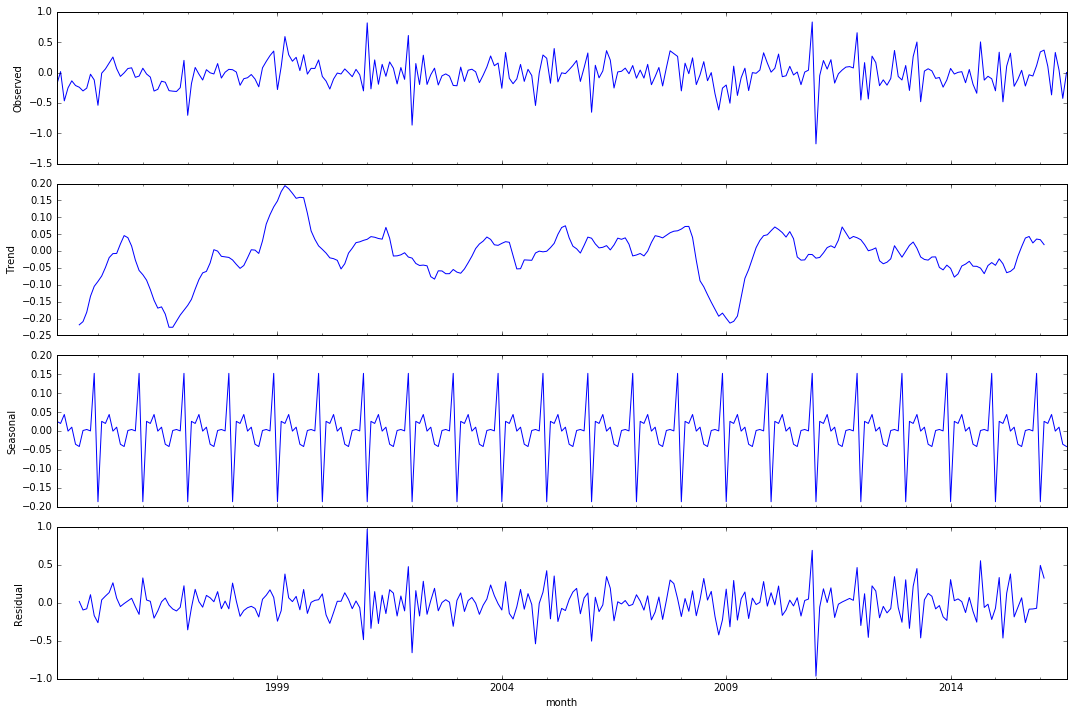

In [7]:
data['wages_box_diff2'] = data.wages_box_diff - data.wages_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wages_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wages_box_diff2[13:])[1])

Теперь мы можем смело отвергнуть гипотезу о нестационраности.

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

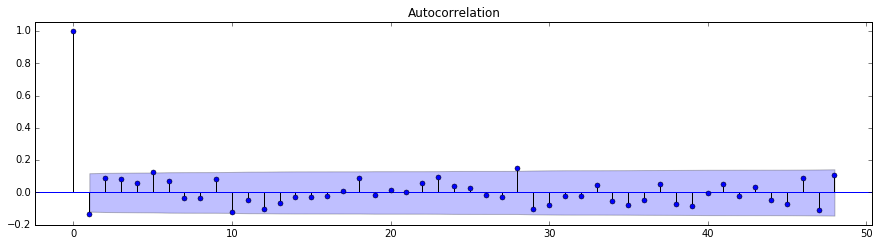

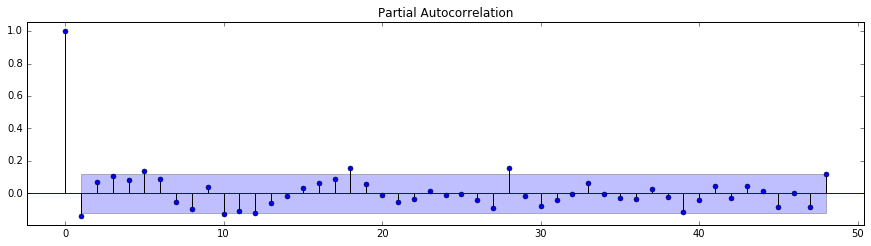

In [8]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.wages_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.wages_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

При выборе начальных приблежений не зыбываем, что ма не должны строить слишком сложную модель.

Сезонных лагов значимо отличающихся от нуля, кроме нулевого не обнаружено. Следовательно, Q=0.

Последний несезонный лаг, при котором автокорреляция значима равен 28. Если мы выберем его за начальное приближение, то модель получится слишком сложной, а вот q = 1 нам подойдет.

По аналогии из частичной корреляционной функции получаем, что P=4, p=5.

Начальные приближения: Q=0, q=1, P=4, p=5

In [9]:
ps = range(0, 6)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [10]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

Для каждого набора параметров посчитаем занчение информационного критерия Акаике

In [11]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
     #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.wages_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 2, 0))
('wrong parameters:', (2, 1, 3, 0))
('wrong parameters:', (2, 1, 4, 0))
CPU times: user 8min 31s, sys: 13min 17s, total: 21min 48s
Wall time: 7min 12s


Выведем самые лучшие модели(с минимальным значением информационного критерия)

In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
50  (5, 1, 1, 0) -5.260134
30  (3, 1, 1, 0) -4.995859
45  (5, 0, 1, 0) -4.545933
53  (5, 1, 4, 0) -4.469892
48  (5, 0, 4, 0) -4.238184


Мы подобрали достаточно простую, но в то же время хорошую модель (судя по информационному критерию).

Посмотрим на нее подробнее

In [13]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          wages_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 1)x(1, 1, 0, 12)   Log Likelihood                  10.630
Date:                            Sun, 30 Oct 2016   AIC                             -5.260
Time:                                    18:19:13   BIC                             23.932
Sample:                                01-01-1993   HQIC                             6.443
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2016      0.436      0.462      0.644      -0.653       1.057
ar.L2          0.0993      0.105   

Посмотрим на остатки нашей модели

Критерий Стьюдента: p=0.296182
Критерий Дики-Фуллера: p=0.000000


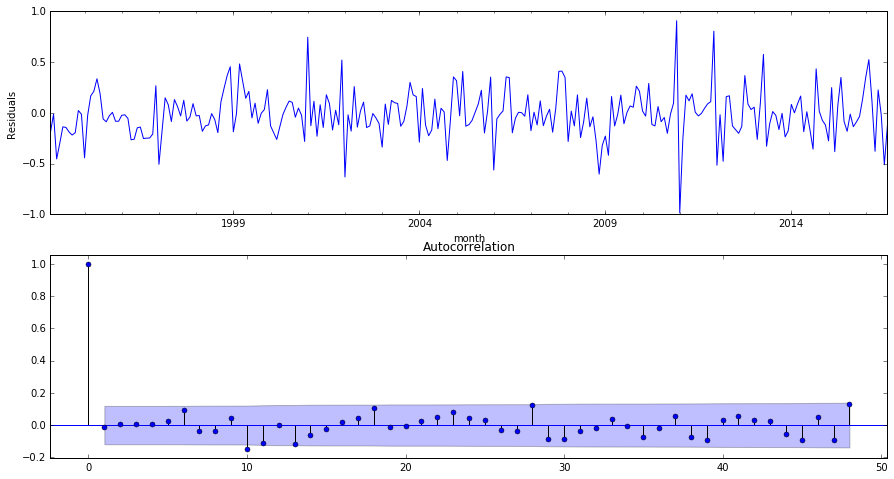

In [14]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

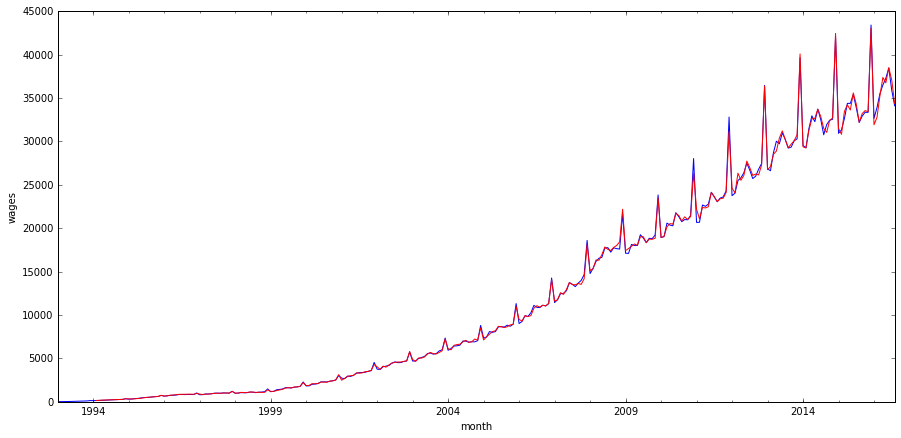

In [15]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('wages')
pylab.show()

Видно, что наша модель хорошо описывает наши данные.

Теперь получим прогноз с помощью нашей модели

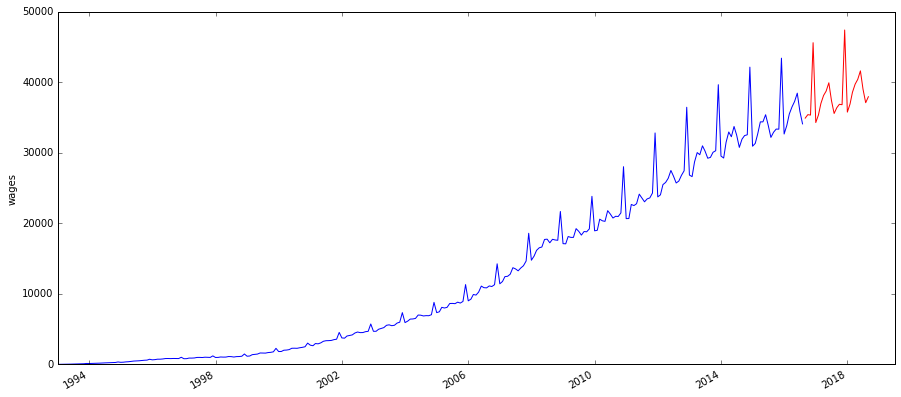

In [40]:
data2 = data[["WAG_C_M"]]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=308), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('wages')
pylab.show()

Прогноз получислся достаточно нормальным. Он передает сезонность, тренд и увеличивающуюся дисперсию